In [1]:
import pickle
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import os
from tqdm import tqdm


sys.path.append("../")
sys.path.append("../covid19_inference")

import covid19_soccer
from covid19_soccer.plot.utils import get_from_trace
import covid19_inference as cov19

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
""" Matplotlib config
"""
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams["figure.figsize"] = [3.4, 2.7]  # APS single column
matplotlib.rcParams["figure.dpi"] = 300  # this primarily affects the size on screen
#matplotlib.rcParams['axes.linewidth'] = 0.3
matplotlib.rcParams["axes.labelcolor"] = "black"
matplotlib.rcParams["axes.edgecolor"] = "black"
matplotlib.rcParams["xtick.color"] = "black"
matplotlib.rcParams["ytick.color"] = "black"
matplotlib.rcParams["xtick.labelsize"] = 8
matplotlib.rcParams["ytick.labelsize"] = 8
matplotlib.rcParams["axes.labelsize"] = 8
matplotlib.rcParams["axes.titlesize"]= 10
matplotlib.rcParams["legend.fontsize"] = 6
matplotlib.rcParams["legend.title_fontsize"] = 8

""" Colors
Done with rcParams / see plot.rcParams
"""


""" General configs
"""
fig_path = "./figures"
countries = ["England","Scotland","Germany","France"]
xlim_ts = [datetime.datetime(2021,5,30),datetime.datetime(2021,7,23)] # Plotting range
offset = 0 #offset of soccer games, mainly for sanity checks
width_prior_delay = 0.1

ylims_fraction = { #ylims for fraction plots
    "Germany":[0.8,1.7],
    "Scotland":[0.8,2.3],
    "England":[0.9,1.4],
    "France":[0.65,1.35],
}
ylims_cases = {
    "Germany":[0,200],
    "Scotland":[0,1100],
    "England":[0,1100],
    "France":[0,500],
}
# Save figure as pdf and png        
save_kwargs = {
    "transparent":True,
    "dpi":300,
    "bbox_inches":"tight"
}

In [4]:
def load(fstr):
    with open(fstr, "rb") as f:
         return pickle.load(f)

In [17]:
countries = ["England","Germany"]
tune = 1000
draws = 2000
max_treedepth = 12
traces, models, dls = {}, {}, {}
for country in countries:
    #'UEFA-beta=False-country=England-offset_games=0-draw_delay=True-weighted_alpha_prior=0-prior_delay=-1-width_delay_prior=0.1-sigma_incubation=-1.0-median_width_delay=1.0-tune=200-draws=300-max_treedepth=10.pickled'
    fstr=(f"/data.nst/jdehning/covid_uefa_traces11/UEFA"+
        f"-beta=False"+
        f"-country={country}"+
        f"-offset_data=0"+
        f"-draw_delay=True"+
        f"-weighted_alpha_prior=0"+
        f"-prior_delay=-1"+
        f"-width_delay_prior=0.1"+
        f"-sigma_incubation=-1.0"+
        f"-median_width_delay=1.0"+
        f"-interval_cps=10.0"+
        f"-tune={tune}"+
        f"-draws={draws}"+
        f"-max_treedepth={max_treedepth}.pickled")
    model, trace = load(fstr)
    dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country])
    models[country] = model
    traces[country]=trace
    dls[country]=dl

In [109]:
# Make Germnany model with additional matches like England:

data_begin = datetime.datetime(2021, 6, 1)
data_end = datetime.datetime(2021, 8, 15)
sim_begin = data_begin-datetime.timedelta(days=16)

dl_GER_alt = covid19_soccer.dataloader.Dataloader_gender(
    data_folder="../data/",
    countries=["Germany_alt"],
    offset_data=0,
    data_begin=data_begin,
    data_end=data_end,
    sim_begin=sim_begin,
)

model_GER_alt = covid19_soccer.models.create_model_gender(
    dataloader=dl_GER_alt,
    beta=False,
    use_gamma=True,
    draw_width_delay=True,
    use_weighted_alpha_prior=0,
    prior_delay=-1,
    width_delay_prior=0.1,
    sigma_incubation=-1.0,
    median_width_delay=1.0,
    interval_cps=10.0,
    f_female=0.2,
)

INFO     [covid19_soccer.utils] pr_sigma_lambda was set to default value 0.2
INFO     [covid19_soccer.utils] pr_median_lambda was set to default value 0.125
INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_soccer.effect_gender] R_t_soccer with deltas
INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_E
INFO     [covid19_soccer.compartmental_models] kernelized spread soccer
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_soccer.delay_by_weekday] Delaying cases by weekday
INFO     [covid19_inference.model.week_modulation] Week modulation


In [110]:
poster_ENG = traces["England"].posterior
poster_GER = traces["Germany"].posterior
ids_ENG_games = np.argwhere(dls["England"].alpha_prior[0] >0)[:,0]
ids_GER_games = np.argwhere(dls["Germany"].alpha_prior[0] >0)[:,0]
ids_GER_alt_games = np.argwhere(dl_GER_alt.alpha_prior[0] >0)[:,0]
mean_eff_ENG = np.mean(poster_ENG["alpha_R"][:,:,ids_ENG_games[:4]], axis=-1)
mean_eff_GER = np.mean(poster_GER["alpha_R"][:,:,ids_GER_games], axis=-1)
ratio_eff_size = mean_eff_GER/mean_eff_ENG

#alpha_R_new = np.zeros(poster_ENG["alpha_R"].shape[:2] + dl_GER_alt.alpha_prior[0].shape)

alpha_R_new = poster_ENG["alpha_R"][:,:,ids_ENG_games[4:]]*ratio_eff_size
Delta_alpha_g_new = (alpha_R_new-poster_GER["alpha_mean"].values[...,np.newaxis])/poster_GER["sigma_alpha_g"].values[...,np.newaxis]

Delta_alpha_g_sparse = np.zeros(poster_ENG["alpha_R"].shape[:2] + ids_GER_alt_games.shape)
Delta_alpha_g_sparse[:,:,:4] = poster_GER["Delta_alpha_g_sparse"]
Delta_alpha_g_sparse[:,:,4:] = Delta_alpha_g_new

#alpha_R_new[:,:,ids_GER_alt_games[:4]] = poster_GER["alpha_R"][:,:,ids_GER_games]
#alpha_R_new[:,:,ids_GER_alt_games[4:]] = poster_ENG["alpha_R"][:,:,ids_ENG_games[4:]]*ratio_eff_size


#poster_ENG["alpha_R"]*dls["England"].alpha_prior[]

In [114]:
plt.hist(ratio_eff_size)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-5.31103759, -3.87319224, -2.43534688, -0.99750153,  0.44034382,
         1.87818918,  3.31603453,  4.75387988,  6.19172524,  7.62957059,
         9.06741594]),
 <a list of 2000 BarContainer objects>)

In [128]:
import xarray as xr
import pymc3 as pm
trace_GER_alt = traces["Germany"].copy()
trace_GER_alt.posterior.drop_dims("Delta_alpha_g_sparse_dim_0")
trace_GER_alt.posterior.drop_vars("Delta_alpha_g_sparse")
#trace_GER_alt.posterior.reset_coords("alpha_R_dim_0", drop=True)
trace_GER_alt.posterior["Delta_alpha_g_sparse"] = xr.DataArray(Delta_alpha_g_sparse, dims=poster_GER["alpha_R"].dims[:2] + ("Delta_alpha_g_sparse_dim_new",))
#trace_GER_alt.posterior.assign(alpha_R=lambda x: (trace_GER_alt.posterior["alpha_R"].dims, alpha_R_new))
cases_what_if = pm.fast_sample_posterior_predictive(trace_GER_alt, model=model_GER_alt, var_names=['new_E_t', 'new_cases', "alpha_R", "R_t_soccer", "R_t_add_fact"], keep_size=True)

In [ ]:
plt.plot()

In [78]:
cases_without_effect['new_cases'].shape

(8, 2000, 108, 2)

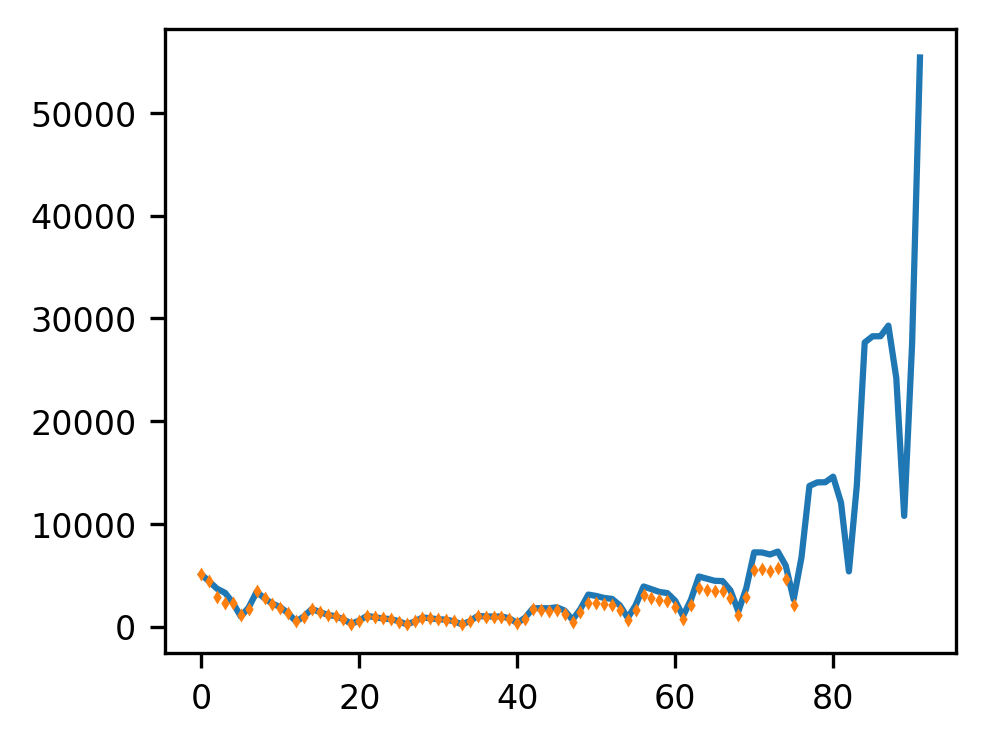

In [113]:
plt.plot(np.sum(np.median(cases_what_if['new_cases'], axis=(0,1)), axis=-1)[16:])
#plt.plot(np.sum(np.median(poster_GER['new_cases'], axis=(0,1)), axis=-1)[16:])
plt.plot(np.sum(dls['Germany'].new_cases_obs, axis=(-2,-1)), marker="d",ms=1, lw=0)

#plt.plot(np.median(cases_without_effect, axis=(0,1)))
plt.show()

/home/jdehning/repositories/covid19_soccer/notebooks/../covid19_soccer/plot/other.py:694: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_male, lw=2.5,),)
/home/jdehning/repositories/covid19_soccer/notebooks/../covid19_soccer/plot/other.py:698: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_female, lw=2.5,),)


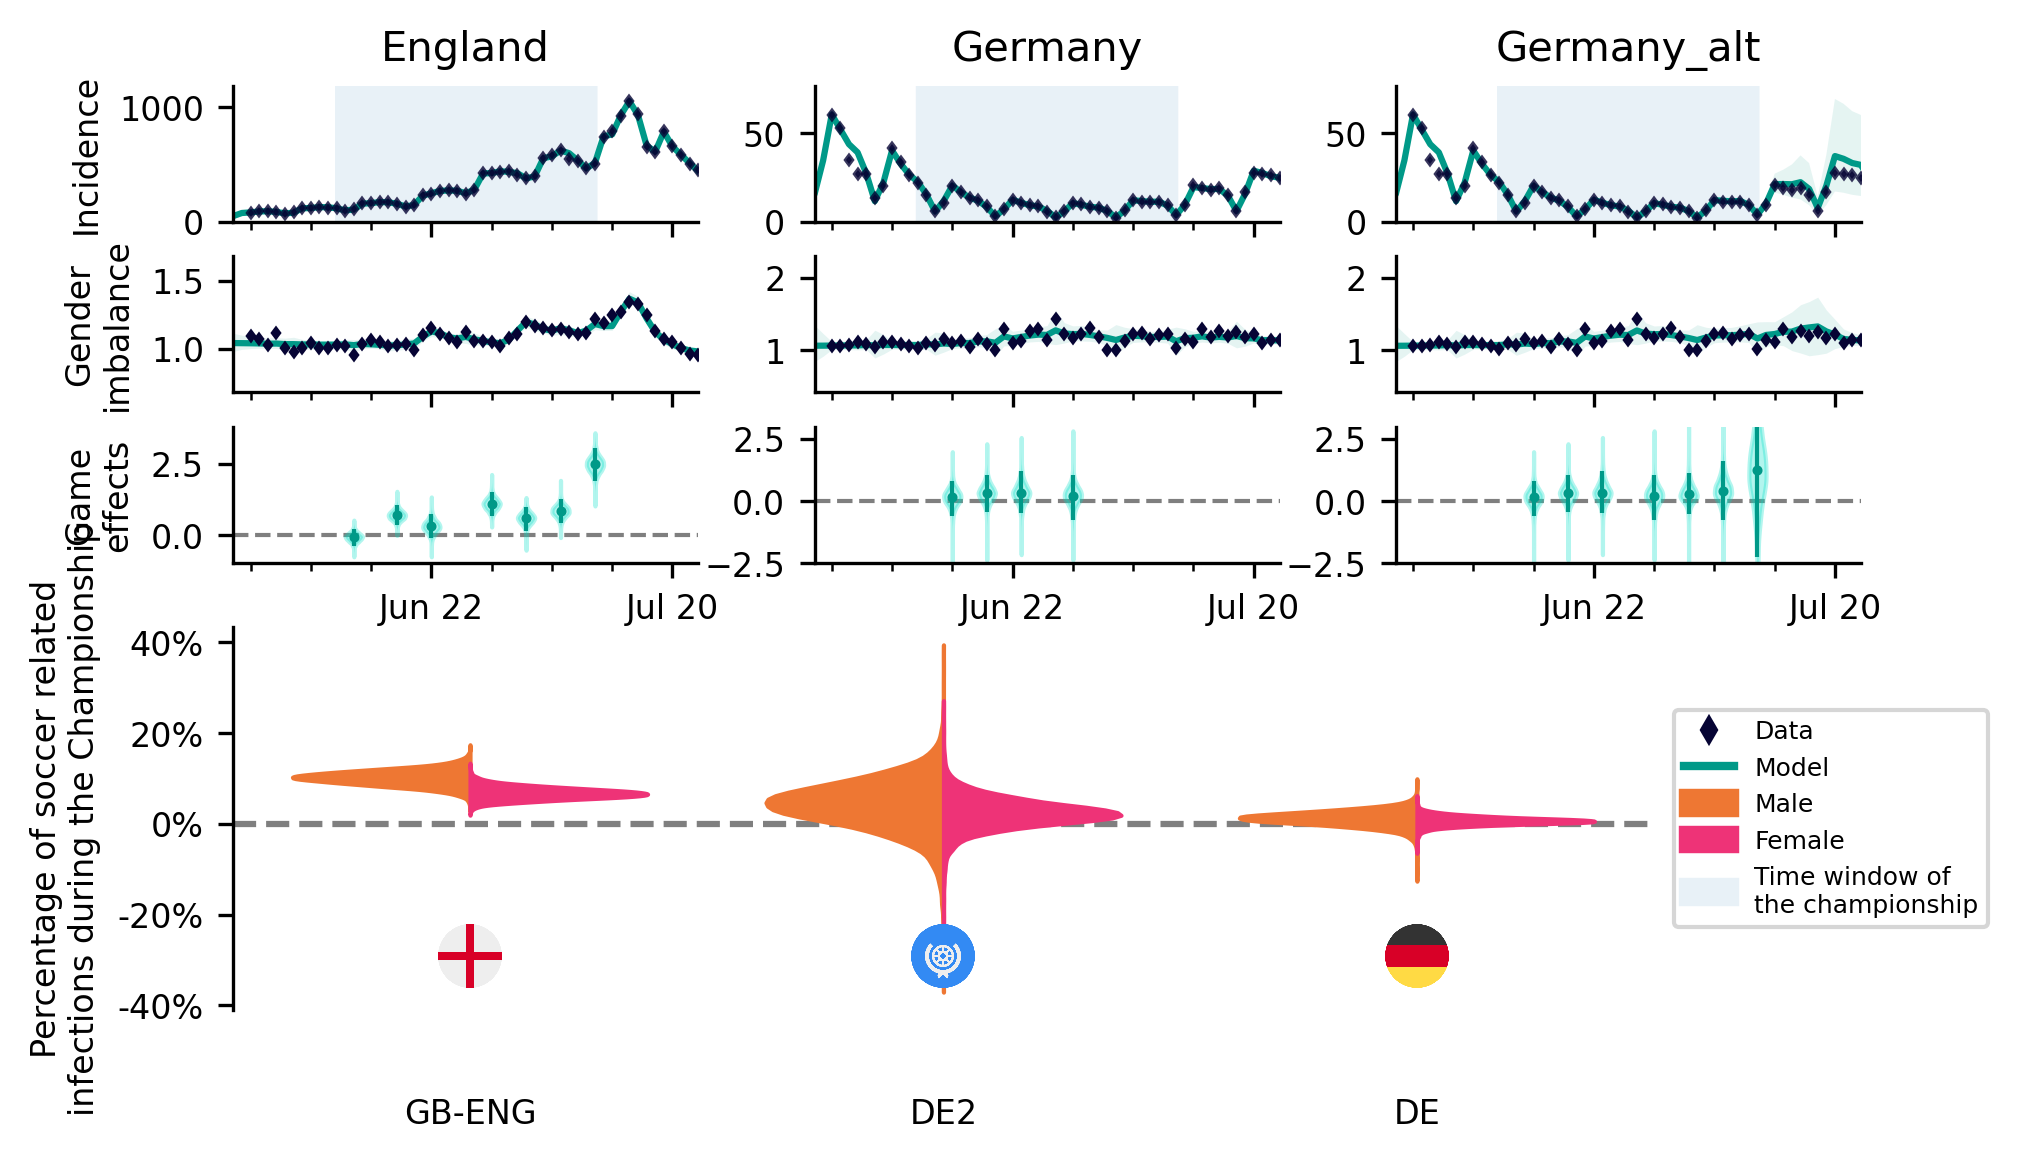

In [167]:
fig = plt.figure(figsize=(7, 4))
trace_GER_alt.posterior['new_cases'].values = cases_what_if['new_cases']
trace_GER_alt.posterior['new_E_t'].values = cases_what_if['new_E_t']
trace_GER_alt.posterior['R_t_add_fact'].values = cases_what_if['R_t_add_fact']
#trace_GER_alt.posterior['alpha_R'].values = cases_what_if['alpha_R']
trace_GER_alt.posterior.drop_dims("alpha_R_dim_0")
trace_GER_alt.posterior.drop_vars("alpha_R")
trace_GER_alt.posterior["alpha_R"] = xr.DataArray(cases_what_if['alpha_R'], dims=poster_GER["alpha_R"].dims[:2] + ("alpha_R_dim_new2",))
trace_GER_alt.posterior['R_t_soccer'].values = cases_what_if['R_t_soccer']

traces["Germany_alt"] = trace_GER_alt
dls["Germany_alt"] = dl_GER_alt
models["Germany_alt"] = model_GER_alt
dls['England'].timetable = dls['England'].timetable[:53]
dls['Germany'].timetable = dls['Germany'].timetable[:53]


axes = covid19_soccer.plot.overview.multi_v2(list(traces.values()),
    list(models.values()),
    list(dls.values()),
    selected_index=[0, 1, 2],
    fig=fig,
    xlim=xlim_ts,
    nColumns=3)
axes[2][2].set_ylim(-2.5,3)
axes[1][2].set_ylim(-2.5,3)

fig.savefig(f"{fig_path}/Germany_what_if.pdf", **save_kwargs)
fig.savefig(f"{fig_path}/Germany_what_if.pdf", **save_kwargs)
plt.show()

#covid19_soccer.plot.timeseries.incidence(ax, trace=trace_GER_alt, model=model_GER_alt, dl=dl_GER_alt)
#plt.show()

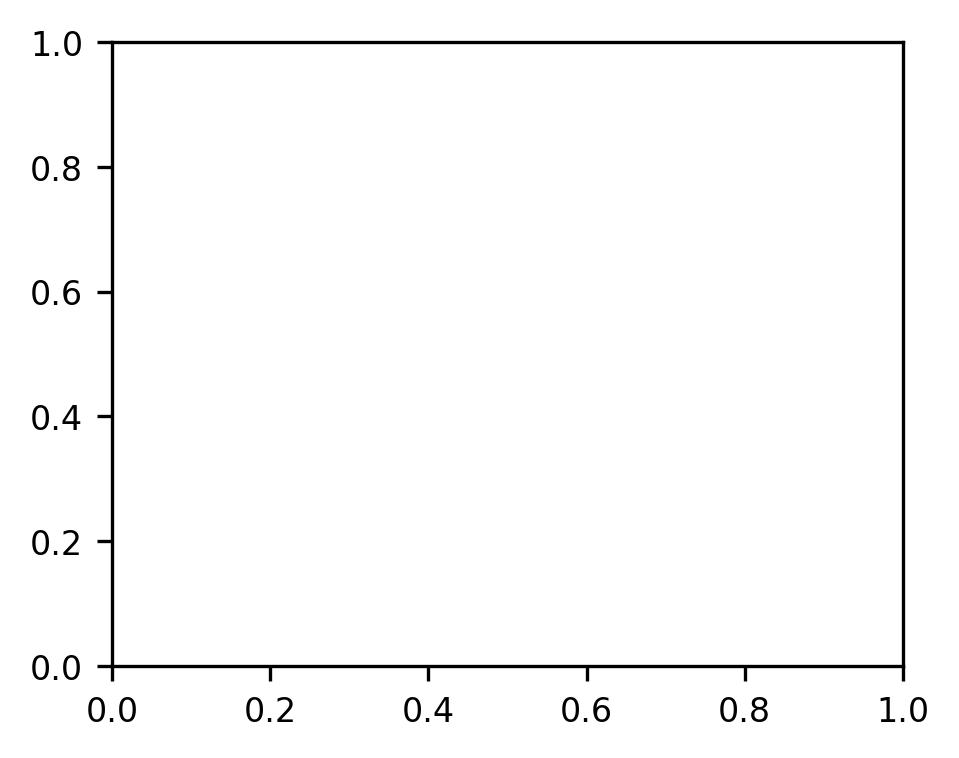

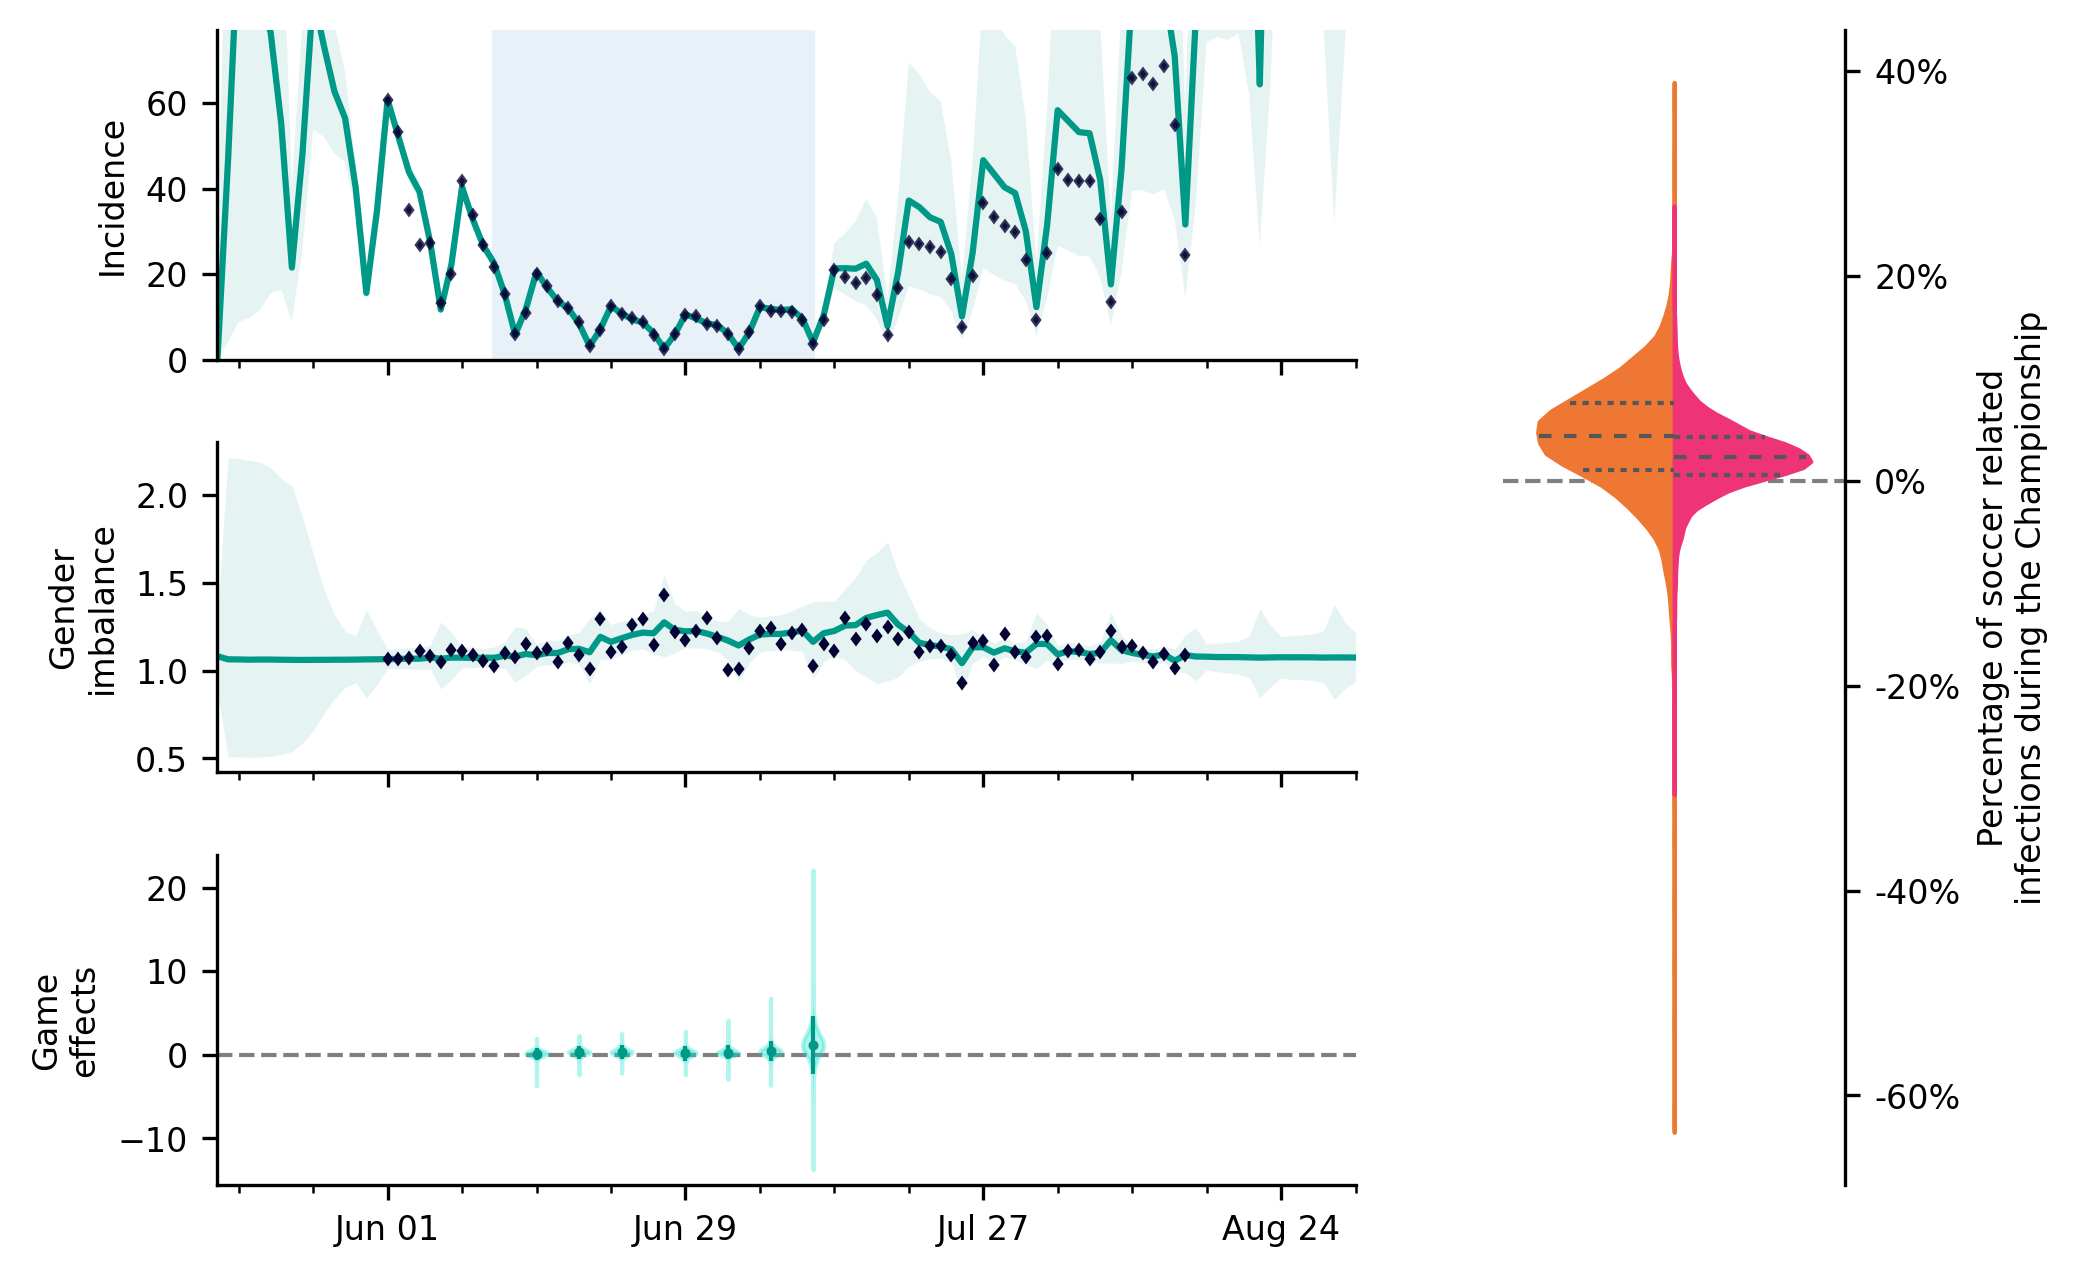

In [137]:
f, ax = plt.subplots()


covid19_soccer.plot.overview.single(trace=trace_GER_alt, model=model_GER_alt, dl=dl_GER_alt)
plt.show()